In [12]:
import spacy
sp = spacy.load('en_core_web_sm')

In [2]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nupur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

In [4]:
import pyLDAvis
import pyLDAvis.gensim_models 
import matplotlib.pyplot as plt 

## Looking at our Data

In [5]:
df = pd.read_excel ('reviews.xlsx')
reviews = list(df['body'])
reviews[:2]

["I am a gentleman of size.  A size large enough that it is statistically unlikely that anyone reading this review will be larger.  I purchased this mattress because my old spring-based unit had finally reached its end of life and I was casting about for a replacement.  When you're a size-enhanced individual, however, maths gets involved.  Your options decrease.I rolled the dice on this model of mattress because, at the time of purchase, it was a little over $300 Canadian.  At time of purchase, this is about the price of a bargain spring mattress.  I had serious doubt that this would support me, but was worth the risk.The result was beyond my wildest expectations.  The mattress provides amazing support, both for myself and my wife.  I haven't slept this well in 20 years.Now, I have no way of knowing how long this mattress will last in this condition.  Continued use will no doubt reduce the firmness and support of the foam.  Just as spring mattresses eventually reach end of life, so too

#### Detect and Remove Non-English

In [16]:
#https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430
#https://stackoverflow.com/questions/66433496/value-error-nlp-add-pipelanguagedetector-name-language-detector-last-tru
from spacy_langdetect import LanguageDetector
from spacy.language import Language

def create_lang_detector(nlp, name):
    return LanguageDetector()

Language.factory("language_detector", func=create_lang_detector)

sp.add_pipe('language_detector', last=True)

ValueError: [E004] Can't set up pipeline component: a factory for 'language_detector' already exists. Existing factory: <function create_lang_detector at 0x00000268E29A8CA0>. New factory: <function create_lang_detector at 0x00000268E29A8F70>

In [20]:
[review for review in reviews if sp(review)._.language['language'] != 'en']

["J'ai ce matelas depuis +de 2mois et je vous recommande fortement de porter attention à la fermeté que vous choisirez. Cela sera salutaire entre le soulagement de vos douleurs ou la créations de nouvelles douleurs.FERMETÉ :-6pouces: moelleux/peu ferme (5/10)-8pouces: moelleux/ moyen ferme (7/10)-10pouces: très ferme (10/10)-12pouces : extrêmement ferme (15/10)J'ai choisi le 10pouces dû au fait que, depuis la grossesse j'ai des douleurs au dos, au cou, au bassin, bref la totalité de mon squelette. Mon ancien matelas s'enfonçait et ne supportait plus mon poids. Donc, je pensais que plus ferme serait le mieux. Le PROBLÈME c'est qu'il est TROP ferme et je dois souvent changer de position durant la nuit. (Je suis 140lbs pour 5.6 pieds)TOUTEFOIS, il soutient bien mon dos et soulage mes maux. Ma colonne est bien alignée durant la nuit et je sens moins de pression mais il me cause des raideurs si j'y dors plus de trois heures; ce qui m'empêchent de paisiblement dormir.À la réception, pour qu'

In [37]:
en_reviews = [review for review in reviews if sp(review)._.language['language'] == 'en']
len(en_reviews)

901

## Data Pre-processing

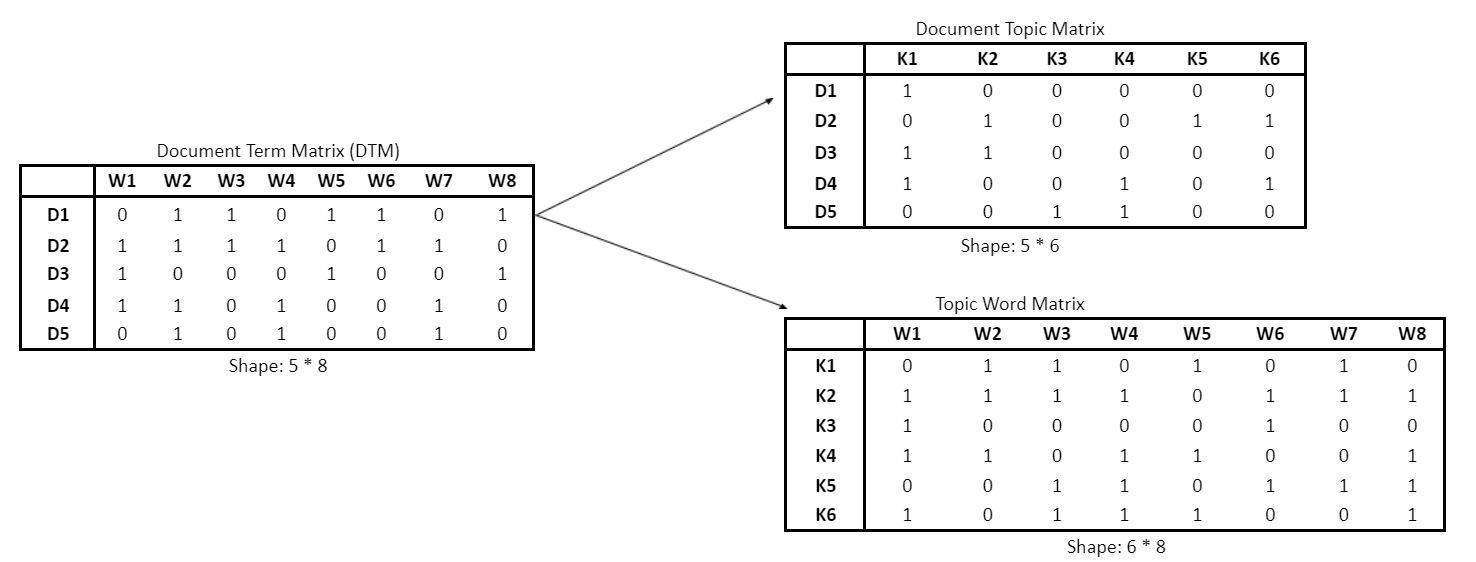

In order to create an LDA model, we have to convert our corpus (all reviews) into the above Document Term Matrix. This pre-processing is the most important step in LDA. 

#### Clean text

In [22]:
#Convert symbol inch to word inch
reviews = [re.sub("\"","inch",review) for review in en_reviews]

#Replace long dash
reviews = [re.sub("—",' ',review) for review in reviews]

#Convert numbers to words and remove punctuation
from num2words import num2words

cleaned_reviews = []

for review in reviews:
    numbers = [int(n) for n in set(re.findall(r'\d+',review))]
    numbers = sorted(numbers,reverse=True)
    for number in numbers:
        word = num2words(number) + " "
        review = review.replace(str(number),word)
    #review = review.translate(str.maketrans(' ',' ',string.punctuation))
    cleaned_reviews.append(review)


cleaned_reviews[0]

"I am a gentleman of size.  A size large enough that it is statistically unlikely that anyone reading this review will be larger.  I purchased this mattress because my old spring-based unit had finally reached its end of life and I was casting about for a replacement.  When you're a size-enhanced individual, however, maths gets involved.  Your options decrease.I rolled the dice on this model of mattress because, at the time of purchase, it was a little over $three hundred  Canadian.  At time of purchase, this is about the price of a bargain spring mattress.  I had serious doubt that this would support me, but was worth the risk.The result was beyond my wildest expectations.  The mattress provides amazing support, both for myself and my wife.  I haven't slept this well in twenty  years.Now, I have no way of knowing how long this mattress will last in this condition.  Continued use will no doubt reduce the firmness and support of the foam.  Just as spring mattresses eventually reach end 

#### Tokenize and Remove Stop Words

In [23]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['bed', 'mattress'])

tokenized = [[word for word in simple_preprocess(str(cleaned_review)) if word not in stop_words] for cleaned_review in cleaned_reviews]
print (tokenized[0])

['gentleman', 'size', 'size', 'large', 'enough', 'statistically', 'unlikely', 'anyone', 'reading', 'review', 'larger', 'purchased', 'old', 'spring', 'based', 'unit', 'finally', 'reached', 'end', 'life', 'casting', 'replacement', 'size', 'enhanced', 'individual', 'however', 'maths', 'gets', 'involved', 'options', 'decrease', 'rolled', 'dice', 'model', 'time', 'purchase', 'little', 'three', 'hundred', 'canadian', 'time', 'purchase', 'price', 'bargain', 'spring', 'serious', 'doubt', 'would', 'support', 'worth', 'risk', 'result', 'beyond', 'wildest', 'expectations', 'provides', 'amazing', 'support', 'wife', 'slept', 'well', 'twenty', 'years', 'way', 'knowing', 'long', 'last', 'condition', 'continued', 'use', 'doubt', 'reduce', 'firmness', 'support', 'foam', 'spring', 'mattresses', 'eventually', 'reach', 'end', 'life', 'must', 'foam', 'said', 'honestly', 'think', 'lifespan', 'serious', 'consideration', 'quality', 'item', 'confident', 'getting', 'least', 'years', 'even', 'size', 'point', 'pe

#### Lemmatize
Lemmatization is the process of converting a word to its base form. 

In [24]:
lemma_list = [[token.lemma_ for token in sp(" ".join(review))] for review in tokenized] 
print (lemma_list[0])

['gentleman', 'size', 'size', 'large', 'enough', 'statistically', 'unlikely', 'anyone', 'read', 'review', 'large', 'purchase', 'old', 'spring', 'base', 'unit', 'finally', 'reach', 'end', 'life', 'cast', 'replacement', 'size', 'enhance', 'individual', 'however', 'math', 'get', 'involve', 'option', 'decrease', 'roll', 'dice', 'model', 'time', 'purchase', 'little', 'three', 'hundred', 'canadian', 'time', 'purchase', 'price', 'bargain', 'spring', 'serious', 'doubt', 'would', 'support', 'worth', 'risk', 'result', 'beyond', 'wildest', 'expectation', 'provide', 'amazing', 'support', 'wife', 'sleep', 'well', 'twenty', 'year', 'way', 'know', 'long', 'last', 'condition', 'continue', 'use', 'doubt', 'reduce', 'firmness', 'support', 'foam', 'spring', 'mattress', 'eventually', 'reach', 'end', 'life', 'must', 'foam', 'say', 'honestly', 'think', 'lifespan', 'serious', 'consideration', 'quality', 'item', 'confident', 'getting', 'least', 'year', 'even', 'size', 'point', 'perhaps', 'quality', 'sleep', '

#### Create tf-idf (term-frequency, inverse document frequency)
TF-IDF is a popular approach used to weigh terms for NLP tasks because it assigns a value to a term according to its importance in a document scaled by its importance across all documents in your corpus, which mathematically eliminates naturally occuring words in the English language, and selects words that are more descriptive of your text. 

In [25]:
#Create Dictionary and Bag of Words
#https://www.tutorialspoint.com/gensim/gensim_creating_tf_idf_matrix.htm
dictionary = corpora.Dictionary()
bag = [dictionary.doc2bow(doc, allow_update=True) for doc in lemma_list]

print([(dictionary[id], freq) for id, freq in bag[0]])

[('ability', 1), ('able', 1), ('accomplish', 1), ('amazing', 1), ('anyone', 1), ('bargain', 1), ('base', 1), ('beyond', 1), ('broken', 1), ('buy', 1), ('canadian', 2), ('cast', 1), ('come', 1), ('condition', 1), ('confident', 1), ('consideration', 1), ('continue', 1), ('decrease', 1), ('dice', 1), ('difference', 1), ('do', 1), ('doubt', 2), ('end', 2), ('enhance', 1), ('enough', 1), ('even', 1), ('eventually', 1), ('every', 2), ('expectation', 1), ('finally', 1), ('firmness', 1), ('first', 2), ('foam', 2), ('fold', 1), ('gentleman', 1), ('get', 2), ('getting', 1), ('glad', 1), ('honestly', 1), ('however', 1), ('hundred', 2), ('individual', 1), ('involve', 1), ('item', 1), ('know', 1), ('large', 2), ('last', 1), ('least', 1), ('life', 2), ('lifespan', 1), ('like', 1), ('little', 1), ('long', 1), ('math', 1), ('mattress', 1), ('model', 1), ('morning', 2), ('must', 1), ('new', 1), ('night', 3), ('old', 1), ('one', 1), ('option', 1), ('pay', 1), ('perhaps', 1), ('point', 1), ('price', 1), 

In [26]:
#https://www.tutorialspoint.com/gensim/gensim_creating_tf_idf_matrix.htm
model = TfidfModel(bag, smartirs='ntc')

In [27]:
#Apply model to the bag of words we created previously 
tfidf = model[bag]

In [28]:
#Human-readable version of corpus
for doc in tfidf:
    print ([(dictionary[id], np.round(freq,2)) for id, freq in doc])

[('ability', 0.13), ('able', 0.06), ('accomplish', 0.13), ('amazing', 0.05), ('anyone', 0.07), ('bargain', 0.11), ('base', 0.07), ('beyond', 0.1), ('broken', 0.11), ('buy', 0.02), ('canadian', 0.19), ('cast', 0.13), ('come', 0.04), ('condition', 0.09), ('confident', 0.11), ('consideration', 0.13), ('continue', 0.09), ('decrease', 0.11), ('dice', 0.11), ('difference', 0.08), ('do', 0.06), ('doubt', 0.2), ('end', 0.12), ('enhance', 0.13), ('enough', 0.06), ('even', 0.05), ('eventually', 0.08), ('every', 0.12), ('expectation', 0.08), ('finally', 0.08), ('firmness', 0.06), ('first', 0.07), ('foam', 0.06), ('fold', 0.08), ('gentleman', 0.11), ('get', 0.05), ('getting', 0.09), ('glad', 0.07), ('honestly', 0.06), ('however', 0.05), ('hundred', 0.08), ('individual', 0.11), ('involve', 0.13), ('item', 0.08), ('know', 0.06), ('large', 0.14), ('last', 0.05), ('least', 0.07), ('life', 0.16), ('lifespan', 0.13), ('like', 0.03), ('little', 0.04), ('long', 0.05), ('math', 0.13), ('mattress', 0.05), (

[('least', 0.21), ('like', 0.09), ('little', 0.14), ('purchase', 0.11), ('sleep', 0.06), ('year', 0.13), ('hour', 0.1), ('open', 0.13), ('upon', 0.25), ('eight', 0.11), ('firm', 0.08), ('let', 0.17), ('month', 0.13), ('forty', 0.16), ('odour', 0.21), ('other', 0.21), ('mention', 0.27), ('may', 0.21), ('side', 0.13), ('package', 0.2), ('medium', 0.2), ('baby', 0.28), ('ago', 0.21), ('past', 0.22), ('rise', 0.21), ('form', 0.23), ('reception', 0.39)]
[('buy', 0.04), ('first', 0.06), ('foam', 0.06), ('point', 0.11), ('price', 0.05), ('say', 0.06), ('size', 0.12), ('sleep', 0.12), ('use', 0.06), ('would', 0.05), ('memory', 0.15), ('comfortable', 0.03), ('delivery', 0.11), ('king', 0.1), ('smell', 0.05), ('expand', 0.06), ('firm', 0.09), ('fully', 0.07), ('main', 0.17), ('soft', 0.06), ('comfort', 0.09), ('great', 0.05), ('noticeable', 0.14), ('overall', 0.1), ('pleasant', 0.17), ('surprise', 0.13), ('without', 0.11), ('keep', 0.1), ('remain', 0.17), ('fantastic', 0.13), ('negative', 0.14),

[('get', 0.07), ('however', 0.14), ('hundred', 0.11), ('long', 0.13), ('one', 0.06), ('price', 0.08), ('really', 0.11), ('say', 0.1), ('size', 0.1), ('week', 0.12), ('worth', 0.16), ('full', 0.2), ('inch', 0.07), ('day', 0.09), ('two', 0.07), ('eight', 0.1), ('take', 0.21), ('corner', 0.13), ('go', 0.1), ('lot', 0.16), ('month', 0.12), ('comfort', 0.14), ('good', 0.08), ('odour', 0.19), ('properly', 0.2), ('strong', 0.4), ('sure', 0.14), ('instruction', 0.2), ('wrong', 0.19), ('decompress', 0.19), ('hate', 0.27), ('still', 0.21), ('far', 0.14), ('addition', 0.3), ('regard', 0.26)]
[('one', 0.08), ('support', 0.17), ('use', 0.12), ('year', 0.14), ('shape', 0.22), ('give', 0.16), ('good', 0.19), ('value', 0.21), ('touch', 0.29), ('already', 0.25), ('everywhere', 0.36), ('ventilate', 0.35), ('body', 0.21), ('deform', 0.39), ('uniform', 0.43)]
[('little', 0.14), ('long', 0.14), ('use', 0.11), ('feel', 0.23), ('need', 0.14), ('edge', 0.21), ('height', 0.22), ('touch', 0.27), ('foot', 0.27),

## Building the model

In [31]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=tfidf,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [32]:
pprint(lda_model.print_topics())

[(0,
  '0.017*"matress" + 0.017*"perfect" + 0.016*"hard" + 0.014*"rv" + '
  '0.012*"absolutely" + 0.010*"we" + 0.009*"star" + 0.009*"hip" + '
  '0.008*"camper" + 0.008*"fantastic"'),
 (1,
  '0.011*"rise" + 0.010*"odour" + 0.009*"advertise" + 0.009*"soon" + '
  '0.008*"whole" + 0.008*"spare" + 0.006*"already" + 0.006*"cottage" + '
  '0.005*"regular" + 0.005*"bought"'),
 (2,
  '0.014*"home" + 0.011*"adult" + 0.008*"consider" + 0.007*"huge" + '
  '0.006*"although" + 0.005*"cat" + 0.004*"tall" + 0.004*"coil" + '
  '0.004*"unfold" + 0.004*"metal"'),
 (3,
  '0.094*"quality" + 0.067*"good" + 0.064*"firm" + 0.011*"comfortable" + '
  '0.011*"great" + 0.010*"love" + 0.009*"inch" + 0.008*"price" + 0.008*"buy" + '
  '0.007*"get"'),
 (4,
  '0.008*"hold" + 0.006*"budget" + 0.005*"ve" + 0.005*"beat" + 0.005*"many" + '
  '0.004*"mention" + 0.004*"rip" + 0.004*"guy" + 0.003*"trick" + '
  '0.003*"possibly"'),
 (5,
  '0.012*"back" + 0.011*"pain" + 0.010*"use" + 0.009*"foam" + 0.009*"night" + '
  '0.009*"

## Evaluating the model

In [34]:
print('\nPerplexity: ', lda_model.log_perplexity(tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemma_list, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.976939661343087

Coherence Score:  0.495577378966127


## Visualize

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, tfidf, dictionary)
vis

c:\users\nupur\documents\nlp-learning\my-spacy-env\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.313138  0.054817       1        1  50.021651
5      0.126590  0.196181       2        1  34.032500
0      0.042628 -0.091262       3        1   6.420942
7      0.031850 -0.051632       4        1   3.885742
1      0.023399 -0.028887       5        1   1.944244
2      0.021518 -0.024377       6        1   1.511873
4      0.017974 -0.016308       7        1   0.788768
9      0.017392 -0.015051       8        1   0.603565
8      0.017066 -0.014294       9        1   0.541390
6      0.014721 -0.009187      10        1   0.249325, topic_info=            Term        Freq       Total Category  logprob  loglift
70       quality  193.000000  193.000000  Default  30.0000  30.0000
273         good  136.000000  136.000000  Default  29.0000  29.0000
171         firm  130.000000  130.000000  Default  28.0000  28.0000
164         back   17.000000   17.000000  Default  27.0000  27.0000
359     daughter    4.000000    4.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
2560  girlfriend    0.003673    0.456607  Topic10  -7.9271   1.1714
2266     special    0.003671    0.437262  Topic10  -7.9277   1.2141
2069     honesty    0.003672    0.453699  Topic10  -7.9274   1.1776
313   unbeatable    0.003675    0.865075  Topic10  -7.9267   0.5329
2275      luxury    0.003674    0.490463  Topic10  -7.9270   1.1001

[418 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
547       3  0.859440  absolutely
509       3  0.592441    actually
1102      4  1.087785      adjust
247       6  0.943082       adult
917       5  0.909516   advertise
...     ...       ...         ...
107       1  0.959366       would
507       4  0.590511       wrong
108       1  0.332427        year
108       2  0.664855        year
859       4  0.670360        zero

[143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 1, 8, 2, 3, 5, 10, 9, 7])